# 프로젝트 : Segmentation map으로 도로 이미지 만들기

In [31]:
# 모듈 import
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

## 1. 데이터 준비하기

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


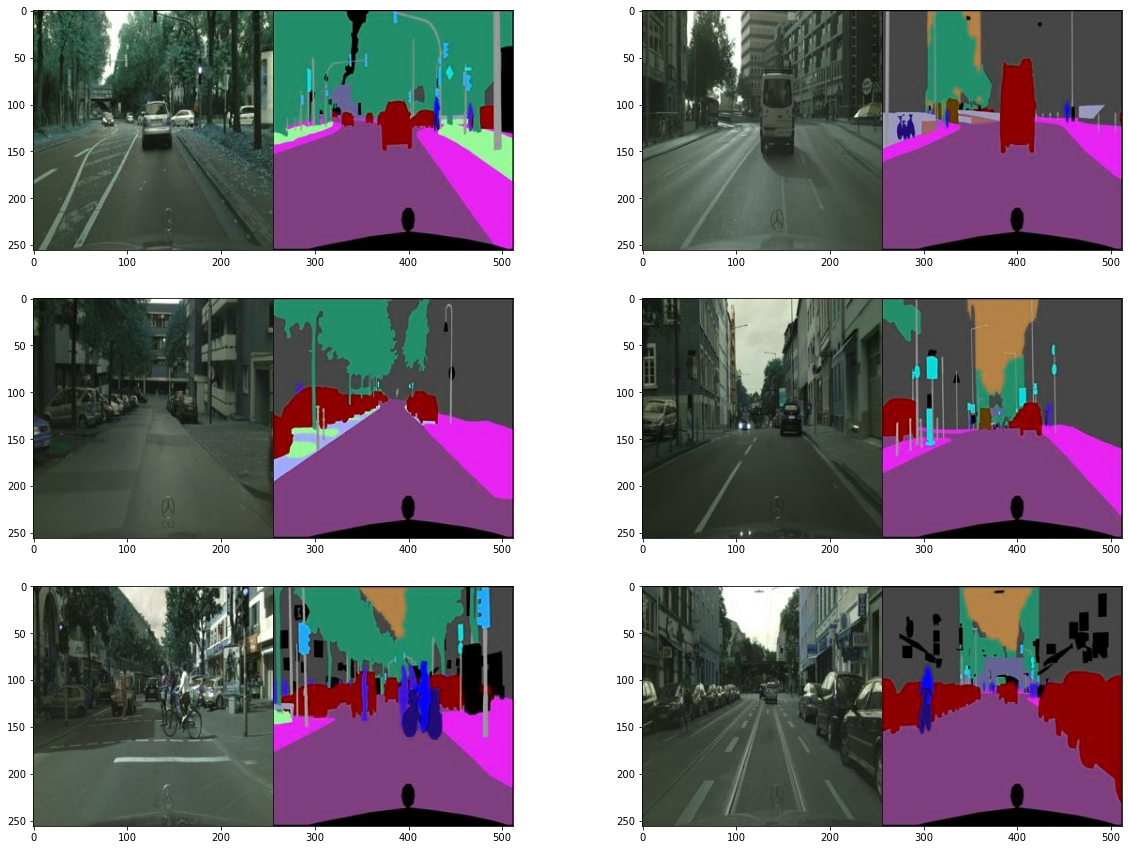

In [3]:
# 이미지 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

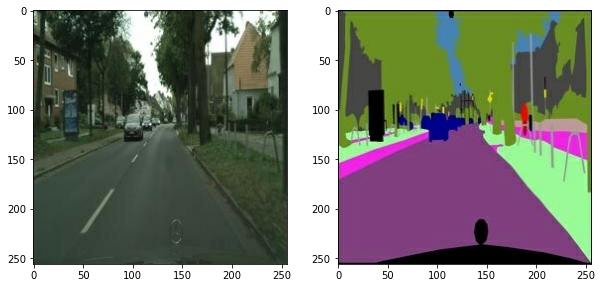

In [6]:
# 이미지 분리
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [7]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# Augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    # 두 이미지를 채널 축으로 연결 (3채널인 경우 6채널로 변환)
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    # 50%의 확률로 Refection padding 또는 constant padding 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 임의로 crop
    out = image.random_crop(padded, size=[256, 256, 6])

    # 50% 확률로 좌우상하 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

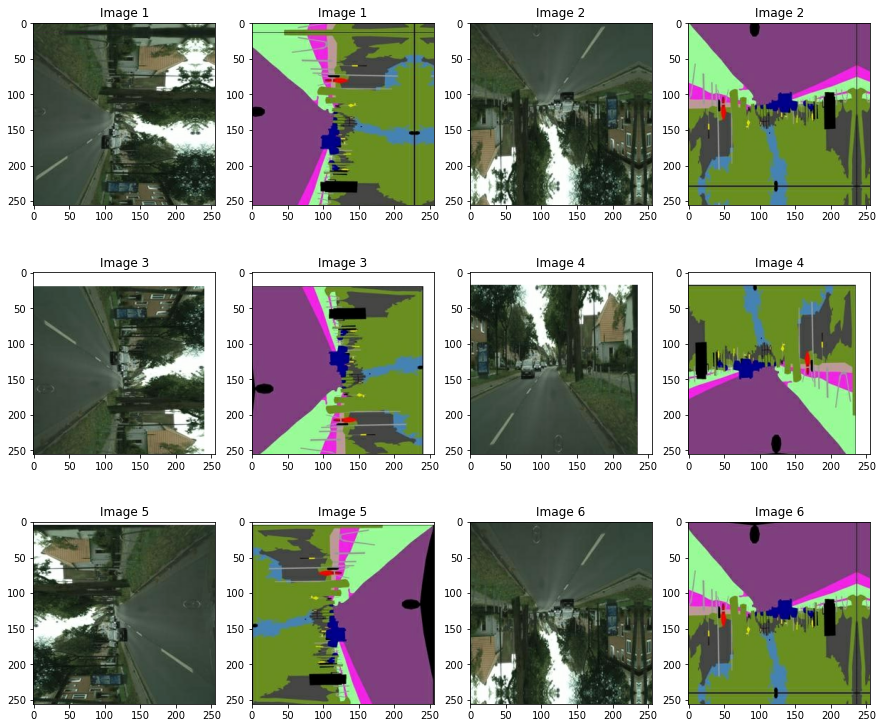

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [9]:
from tensorflow import data

# 학습 노드에서 sketch와 colored 순서가 다름에 주의
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

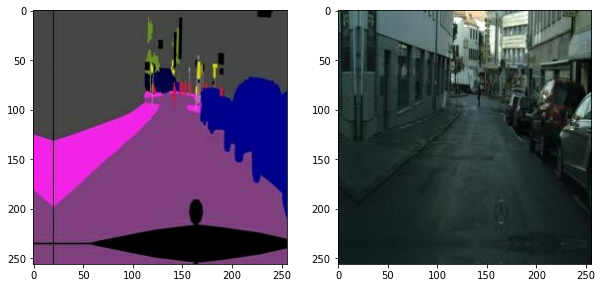

In [10]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Generator 구성하기

In [11]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [12]:
# Decoder   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [13]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 Skip Connection에서 제외
        features = features[:-1]

        # feature의 역순으로 Skip Connection
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # 가장 마지막 축(Channel) 기준으로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성하기

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # 1 만큼 ZeroPadding
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [17]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

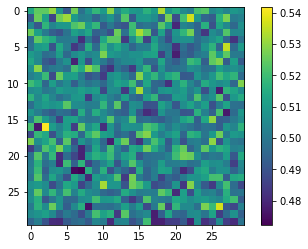

In [18]:
# 임의 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 학습 및 테스트하기

In [19]:
# Loss Function
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [20]:
# Optimizer
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [21]:
# 학습 가중치 업데이트 함수
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [22]:
# 10 epoch 훈련
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8678                     
L1_loss:0.3903                     
Discriminator_loss:1.1642

EPOCH[1] - STEP[20]                     
Generator_loss:0.9750                     
L1_loss:0.2597                     
Discriminator_loss:1.3871

EPOCH[1] - STEP[30]                     
Generator_loss:0.8473                     
L1_loss:0.1925                     
Discriminator_loss:1.2836

EPOCH[1] - STEP[40]                     
Generator_loss:0.8052                     
L1_loss:0.2044                     
Discriminator_loss:1.3754

EPOCH[1] - STEP[50]                     
Generator_loss:0.6243                     
L1_loss:0.1962                     
Discriminator_loss:1.3025

EPOCH[1] - STEP[60]                     
Generator_loss:0.9479                     
L1_loss:0.2145                     
Discriminator_loss:1.2787

EPOCH[1] - STEP[70]                     
Generator_loss:0.9964                     
L1_loss:0.2249                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.2475                     
L1_loss:0.1941                     
Discriminator_loss:0.5166

EPOCH[3] - STEP[80]                     
Generator_loss:1.7744                     
L1_loss:0.1579                     
Discriminator_loss:0.5034

EPOCH[3] - STEP[90]                     
Generator_loss:0.9742                     
L1_loss:0.1832                     
Discriminator_loss:0.9011

EPOCH[3] - STEP[100]                     
Generator_loss:1.3282                     
L1_loss:0.1705                     
Discriminator_loss:1.3584

EPOCH[3] - STEP[110]                     
Generator_loss:2.1140                     
L1_loss:0.1561                     
Discriminator_loss:0.6669

EPOCH[3] - STEP[120]                     
Generator_loss:0.6184                     
L1_loss:0.2485                     
Discriminator_loss:1.0349

EPOCH[3] - STEP[130]                     
Generator_loss:1.0864                     
L1_loss:0.1943                

EPOCH[5] - STEP[130]                     
Generator_loss:1.2739                     
L1_loss:0.1471                     
Discriminator_loss:0.7761

EPOCH[5] - STEP[140]                     
Generator_loss:2.8758                     
L1_loss:0.2037                     
Discriminator_loss:0.7188

EPOCH[5] - STEP[150]                     
Generator_loss:0.6855                     
L1_loss:0.1973                     
Discriminator_loss:0.8461

EPOCH[5] - STEP[160]                     
Generator_loss:2.1110                     
L1_loss:0.1727                     
Discriminator_loss:0.5738

EPOCH[5] - STEP[170]                     
Generator_loss:1.7819                     
L1_loss:0.1889                     
Discriminator_loss:0.4062

EPOCH[5] - STEP[180]                     
Generator_loss:1.2938                     
L1_loss:0.1708                     
Discriminator_loss:1.2446

EPOCH[5] - STEP[190]                     
Generator_loss:1.0528                     
L1_loss:0.1828             

EPOCH[7] - STEP[190]                     
Generator_loss:1.3370                     
L1_loss:0.1821                     
Discriminator_loss:0.8044

EPOCH[7] - STEP[200]                     
Generator_loss:0.8318                     
L1_loss:0.1827                     
Discriminator_loss:2.2260

EPOCH[7] - STEP[210]                     
Generator_loss:2.8699                     
L1_loss:0.1679                     
Discriminator_loss:0.4999

EPOCH[7] - STEP[220]                     
Generator_loss:0.4809                     
L1_loss:0.1695                     
Discriminator_loss:1.4999

EPOCH[7] - STEP[230]                     
Generator_loss:1.3182                     
L1_loss:0.2261                     
Discriminator_loss:0.4525

EPOCH[7] - STEP[240]                     
Generator_loss:0.5648                     
L1_loss:0.2067                     
Discriminator_loss:0.9971

EPOCH[7] - STEP[250]                     
Generator_loss:1.0906                     
L1_loss:0.1964             

EPOCH[9] - STEP[250]                     
Generator_loss:1.6513                     
L1_loss:0.1901                     
Discriminator_loss:0.7787

EPOCH[10] - STEP[10]                     
Generator_loss:2.3565                     
L1_loss:0.1775                     
Discriminator_loss:0.4835

EPOCH[10] - STEP[20]                     
Generator_loss:0.5399                     
L1_loss:0.1716                     
Discriminator_loss:2.1694

EPOCH[10] - STEP[30]                     
Generator_loss:0.9568                     
L1_loss:0.2028                     
Discriminator_loss:1.4666

EPOCH[10] - STEP[40]                     
Generator_loss:2.8707                     
L1_loss:0.1717                     
Discriminator_loss:0.2945

EPOCH[10] - STEP[50]                     
Generator_loss:1.6053                     
L1_loss:0.1837                     
Discriminator_loss:0.3931

EPOCH[10] - STEP[60]                     
Generator_loss:1.5294                     
L1_loss:0.1954             

In [23]:
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of validation examples :", len(os.listdir(val_path)))

number of validation examples : 5


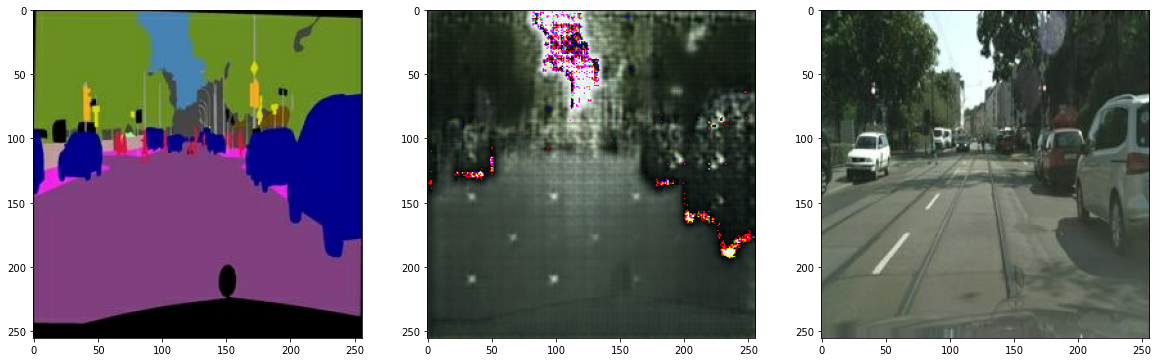

In [24]:
# 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [25]:
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.5736                     
L1_loss:0.1537                     
Discriminator_loss:2.2409

EPOCH[1] - STEP[100]                     
Generator_loss:0.7850                     
L1_loss:0.2205                     
Discriminator_loss:0.7209

EPOCH[1] - STEP[150]                     
Generator_loss:1.6495                     
L1_loss:0.1905                     
Discriminator_loss:0.4512

EPOCH[1] - STEP[200]                     
Generator_loss:1.2811                     
L1_loss:0.2058                     
Discriminator_loss:0.5563

EPOCH[1] - STEP[250]                     
Generator_loss:1.0818                     
L1_loss:0.1371                     
Discriminator_loss:0.6891

EPOCH[2] - STEP[50]                     
Generator_loss:1.4799                     
L1_loss:0.1976                     
Discriminator_loss:0.4831

EPOCH[2] - STEP[100]                     
Generator_loss:0.8090                     
L1_loss:0.1752               

EPOCH[12] - STEP[100]                     
Generator_loss:0.6809                     
L1_loss:0.2120                     
Discriminator_loss:0.8865

EPOCH[12] - STEP[150]                     
Generator_loss:1.7765                     
L1_loss:0.1902                     
Discriminator_loss:0.7346

EPOCH[12] - STEP[200]                     
Generator_loss:1.7136                     
L1_loss:0.1751                     
Discriminator_loss:0.7816

EPOCH[12] - STEP[250]                     
Generator_loss:1.8280                     
L1_loss:0.1738                     
Discriminator_loss:1.0273

EPOCH[13] - STEP[50]                     
Generator_loss:1.4268                     
L1_loss:0.1818                     
Discriminator_loss:0.4093

EPOCH[13] - STEP[100]                     
Generator_loss:1.2589                     
L1_loss:0.1936                     
Discriminator_loss:0.4696

EPOCH[13] - STEP[150]                     
Generator_loss:0.8501                     
L1_loss:0.1565       

EPOCH[23] - STEP[150]                     
Generator_loss:0.5661                     
L1_loss:0.1970                     
Discriminator_loss:0.9540

EPOCH[23] - STEP[200]                     
Generator_loss:2.2110                     
L1_loss:0.1620                     
Discriminator_loss:0.9829

EPOCH[23] - STEP[250]                     
Generator_loss:2.0887                     
L1_loss:0.1935                     
Discriminator_loss:0.5950

EPOCH[24] - STEP[50]                     
Generator_loss:1.2252                     
L1_loss:0.1777                     
Discriminator_loss:0.4655

EPOCH[24] - STEP[100]                     
Generator_loss:1.3600                     
L1_loss:0.1583                     
Discriminator_loss:0.8389

EPOCH[24] - STEP[150]                     
Generator_loss:1.1321                     
L1_loss:0.1837                     
Discriminator_loss:0.8265

EPOCH[24] - STEP[200]                     
Generator_loss:2.1108                     
L1_loss:0.1562       

EPOCH[34] - STEP[200]                     
Generator_loss:2.0313                     
L1_loss:0.2001                     
Discriminator_loss:0.6541

EPOCH[34] - STEP[250]                     
Generator_loss:1.3667                     
L1_loss:0.1907                     
Discriminator_loss:0.3436

EPOCH[35] - STEP[50]                     
Generator_loss:1.0201                     
L1_loss:0.1761                     
Discriminator_loss:1.7770

EPOCH[35] - STEP[100]                     
Generator_loss:1.5497                     
L1_loss:0.2032                     
Discriminator_loss:1.0042

EPOCH[35] - STEP[150]                     
Generator_loss:0.7609                     
L1_loss:0.1692                     
Discriminator_loss:1.3207

EPOCH[35] - STEP[200]                     
Generator_loss:1.9859                     
L1_loss:0.2003                     
Discriminator_loss:0.3011

EPOCH[35] - STEP[250]                     
Generator_loss:2.0574                     
L1_loss:0.1739       

EPOCH[45] - STEP[250]                     
Generator_loss:1.2132                     
L1_loss:0.2031                     
Discriminator_loss:0.4544

EPOCH[46] - STEP[50]                     
Generator_loss:1.7889                     
L1_loss:0.1824                     
Discriminator_loss:0.2999

EPOCH[46] - STEP[100]                     
Generator_loss:0.5335                     
L1_loss:0.1523                     
Discriminator_loss:1.0813

EPOCH[46] - STEP[150]                     
Generator_loss:1.3844                     
L1_loss:0.1465                     
Discriminator_loss:0.8656

EPOCH[46] - STEP[200]                     
Generator_loss:1.3520                     
L1_loss:0.1508                     
Discriminator_loss:1.4546

EPOCH[46] - STEP[250]                     
Generator_loss:1.4388                     
L1_loss:0.1839                     
Discriminator_loss:0.6626

EPOCH[47] - STEP[50]                     
Generator_loss:1.4901                     
L1_loss:0.1973        

EPOCH[57] - STEP[50]                     
Generator_loss:1.1254                     
L1_loss:0.1573                     
Discriminator_loss:1.2325

EPOCH[57] - STEP[100]                     
Generator_loss:2.5190                     
L1_loss:0.1551                     
Discriminator_loss:0.7841

EPOCH[57] - STEP[150]                     
Generator_loss:2.2152                     
L1_loss:0.1969                     
Discriminator_loss:0.1763

EPOCH[57] - STEP[200]                     
Generator_loss:2.2665                     
L1_loss:0.1827                     
Discriminator_loss:1.7063

EPOCH[57] - STEP[250]                     
Generator_loss:0.8156                     
L1_loss:0.2154                     
Discriminator_loss:0.7087

EPOCH[58] - STEP[50]                     
Generator_loss:1.1186                     
L1_loss:0.1934                     
Discriminator_loss:1.4067

EPOCH[58] - STEP[100]                     
Generator_loss:1.6312                     
L1_loss:0.1581        

EPOCH[68] - STEP[100]                     
Generator_loss:1.6002                     
L1_loss:0.1731                     
Discriminator_loss:1.0658

EPOCH[68] - STEP[150]                     
Generator_loss:0.1994                     
L1_loss:0.1857                     
Discriminator_loss:1.9616

EPOCH[68] - STEP[200]                     
Generator_loss:0.8782                     
L1_loss:0.1552                     
Discriminator_loss:1.2867

EPOCH[68] - STEP[250]                     
Generator_loss:1.2546                     
L1_loss:0.1888                     
Discriminator_loss:0.8718

EPOCH[69] - STEP[50]                     
Generator_loss:0.3860                     
L1_loss:0.2081                     
Discriminator_loss:1.8846

EPOCH[69] - STEP[100]                     
Generator_loss:0.9736                     
L1_loss:0.1584                     
Discriminator_loss:0.8808

EPOCH[69] - STEP[150]                     
Generator_loss:0.5244                     
L1_loss:0.2062       

EPOCH[79] - STEP[150]                     
Generator_loss:1.4244                     
L1_loss:0.1500                     
Discriminator_loss:0.7170

EPOCH[79] - STEP[200]                     
Generator_loss:0.7613                     
L1_loss:0.1857                     
Discriminator_loss:0.9319

EPOCH[79] - STEP[250]                     
Generator_loss:1.6262                     
L1_loss:0.1630                     
Discriminator_loss:0.7340

EPOCH[80] - STEP[50]                     
Generator_loss:1.4319                     
L1_loss:0.1680                     
Discriminator_loss:0.6880

EPOCH[80] - STEP[100]                     
Generator_loss:1.6365                     
L1_loss:0.1672                     
Discriminator_loss:0.8869

EPOCH[80] - STEP[150]                     
Generator_loss:0.5278                     
L1_loss:0.1486                     
Discriminator_loss:1.2421

EPOCH[80] - STEP[200]                     
Generator_loss:0.4766                     
L1_loss:0.1845       

EPOCH[90] - STEP[200]                     
Generator_loss:2.0672                     
L1_loss:0.1947                     
Discriminator_loss:0.1765

EPOCH[90] - STEP[250]                     
Generator_loss:0.7041                     
L1_loss:0.1843                     
Discriminator_loss:0.8319

EPOCH[91] - STEP[50]                     
Generator_loss:1.1898                     
L1_loss:0.1667                     
Discriminator_loss:2.5055

EPOCH[91] - STEP[100]                     
Generator_loss:0.7553                     
L1_loss:0.1599                     
Discriminator_loss:1.8603

EPOCH[91] - STEP[150]                     
Generator_loss:0.5974                     
L1_loss:0.1605                     
Discriminator_loss:1.3302

EPOCH[91] - STEP[200]                     
Generator_loss:2.6960                     
L1_loss:0.1772                     
Discriminator_loss:1.1365

EPOCH[91] - STEP[250]                     
Generator_loss:1.2853                     
L1_loss:0.1692       

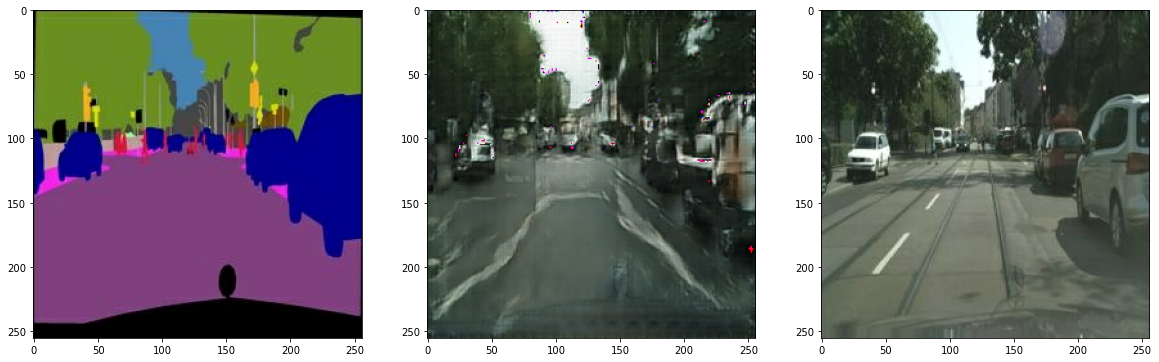

In [26]:
# 100 epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [27]:
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.9005                     
L1_loss:0.1494                     
Discriminator_loss:1.2737

EPOCH[1] - STEP[100]                     
Generator_loss:1.5347                     
L1_loss:0.1371                     
Discriminator_loss:1.1120

EPOCH[1] - STEP[150]                     
Generator_loss:1.3184                     
L1_loss:0.1700                     
Discriminator_loss:0.8738

EPOCH[1] - STEP[200]                     
Generator_loss:1.5208                     
L1_loss:0.1594                     
Discriminator_loss:1.5569

EPOCH[1] - STEP[250]                     
Generator_loss:1.3062                     
L1_loss:0.1634                     
Discriminator_loss:0.5838

EPOCH[2] - STEP[50]                     
Generator_loss:1.8042                     
L1_loss:0.1944                     
Discriminator_loss:0.5320

EPOCH[2] - STEP[100]                     
Generator_loss:0.6388                     
L1_loss:0.1736               

EPOCH[12] - STEP[100]                     
Generator_loss:1.8400                     
L1_loss:0.1638                     
Discriminator_loss:0.4248

EPOCH[12] - STEP[150]                     
Generator_loss:1.3578                     
L1_loss:0.1564                     
Discriminator_loss:0.6278

EPOCH[12] - STEP[200]                     
Generator_loss:0.6115                     
L1_loss:0.1449                     
Discriminator_loss:2.0865

EPOCH[12] - STEP[250]                     
Generator_loss:0.4937                     
L1_loss:0.1706                     
Discriminator_loss:1.2709

EPOCH[13] - STEP[50]                     
Generator_loss:0.8556                     
L1_loss:0.1530                     
Discriminator_loss:0.7396

EPOCH[13] - STEP[100]                     
Generator_loss:1.8086                     
L1_loss:0.1508                     
Discriminator_loss:1.1786

EPOCH[13] - STEP[150]                     
Generator_loss:0.9784                     
L1_loss:0.1828       

EPOCH[23] - STEP[150]                     
Generator_loss:1.4964                     
L1_loss:0.1781                     
Discriminator_loss:0.3743

EPOCH[23] - STEP[200]                     
Generator_loss:1.7100                     
L1_loss:0.1589                     
Discriminator_loss:1.0005

EPOCH[23] - STEP[250]                     
Generator_loss:1.2769                     
L1_loss:0.1724                     
Discriminator_loss:1.0949

EPOCH[24] - STEP[50]                     
Generator_loss:1.7185                     
L1_loss:0.1722                     
Discriminator_loss:0.9681

EPOCH[24] - STEP[100]                     
Generator_loss:1.7939                     
L1_loss:0.1702                     
Discriminator_loss:0.9618

EPOCH[24] - STEP[150]                     
Generator_loss:1.4695                     
L1_loss:0.1560                     
Discriminator_loss:1.1442

EPOCH[24] - STEP[200]                     
Generator_loss:1.4149                     
L1_loss:0.1400       

EPOCH[34] - STEP[200]                     
Generator_loss:0.9854                     
L1_loss:0.1662                     
Discriminator_loss:1.0383

EPOCH[34] - STEP[250]                     
Generator_loss:1.6373                     
L1_loss:0.1562                     
Discriminator_loss:1.3255

EPOCH[35] - STEP[50]                     
Generator_loss:1.5547                     
L1_loss:0.2047                     
Discriminator_loss:0.3524

EPOCH[35] - STEP[100]                     
Generator_loss:1.7526                     
L1_loss:0.1635                     
Discriminator_loss:0.8144

EPOCH[35] - STEP[150]                     
Generator_loss:1.5344                     
L1_loss:0.1424                     
Discriminator_loss:0.5852

EPOCH[35] - STEP[200]                     
Generator_loss:1.6006                     
L1_loss:0.1843                     
Discriminator_loss:0.3187

EPOCH[35] - STEP[250]                     
Generator_loss:1.4986                     
L1_loss:0.1459       

EPOCH[45] - STEP[250]                     
Generator_loss:1.2783                     
L1_loss:0.1945                     
Discriminator_loss:0.5678

EPOCH[46] - STEP[50]                     
Generator_loss:2.4697                     
L1_loss:0.2222                     
Discriminator_loss:0.1329

EPOCH[46] - STEP[100]                     
Generator_loss:0.7595                     
L1_loss:0.1957                     
Discriminator_loss:0.9140

EPOCH[46] - STEP[150]                     
Generator_loss:1.8832                     
L1_loss:0.1795                     
Discriminator_loss:0.2565

EPOCH[46] - STEP[200]                     
Generator_loss:1.3662                     
L1_loss:0.1720                     
Discriminator_loss:0.4345

EPOCH[46] - STEP[250]                     
Generator_loss:1.7618                     
L1_loss:0.1479                     
Discriminator_loss:0.7317

EPOCH[47] - STEP[50]                     
Generator_loss:0.9801                     
L1_loss:0.1575        

EPOCH[57] - STEP[50]                     
Generator_loss:0.6326                     
L1_loss:0.1841                     
Discriminator_loss:1.6428

EPOCH[57] - STEP[100]                     
Generator_loss:2.0978                     
L1_loss:0.1917                     
Discriminator_loss:0.2049

EPOCH[57] - STEP[150]                     
Generator_loss:1.0746                     
L1_loss:0.1861                     
Discriminator_loss:0.5554

EPOCH[57] - STEP[200]                     
Generator_loss:0.8205                     
L1_loss:0.1547                     
Discriminator_loss:0.9274

EPOCH[57] - STEP[250]                     
Generator_loss:0.9382                     
L1_loss:0.1404                     
Discriminator_loss:1.7981

EPOCH[58] - STEP[50]                     
Generator_loss:1.1721                     
L1_loss:0.1724                     
Discriminator_loss:1.9037

EPOCH[58] - STEP[100]                     
Generator_loss:1.4991                     
L1_loss:0.1554        

EPOCH[68] - STEP[100]                     
Generator_loss:0.8458                     
L1_loss:0.1735                     
Discriminator_loss:1.1059

EPOCH[68] - STEP[150]                     
Generator_loss:1.8739                     
L1_loss:0.1857                     
Discriminator_loss:0.2462

EPOCH[68] - STEP[200]                     
Generator_loss:2.4909                     
L1_loss:0.1778                     
Discriminator_loss:0.1707

EPOCH[68] - STEP[250]                     
Generator_loss:1.1327                     
L1_loss:0.1646                     
Discriminator_loss:0.6951

EPOCH[69] - STEP[50]                     
Generator_loss:1.6212                     
L1_loss:0.1527                     
Discriminator_loss:1.1316

EPOCH[69] - STEP[100]                     
Generator_loss:0.7582                     
L1_loss:0.2435                     
Discriminator_loss:0.8429

EPOCH[69] - STEP[150]                     
Generator_loss:0.1253                     
L1_loss:0.1812       

EPOCH[79] - STEP[150]                     
Generator_loss:1.4844                     
L1_loss:0.1485                     
Discriminator_loss:0.4328

EPOCH[79] - STEP[200]                     
Generator_loss:1.9523                     
L1_loss:0.1530                     
Discriminator_loss:0.5913

EPOCH[79] - STEP[250]                     
Generator_loss:0.9140                     
L1_loss:0.1828                     
Discriminator_loss:0.7252

EPOCH[80] - STEP[50]                     
Generator_loss:1.6603                     
L1_loss:0.1532                     
Discriminator_loss:0.7162

EPOCH[80] - STEP[100]                     
Generator_loss:2.6360                     
L1_loss:0.1724                     
Discriminator_loss:1.7808

EPOCH[80] - STEP[150]                     
Generator_loss:1.8677                     
L1_loss:0.1414                     
Discriminator_loss:1.0027

EPOCH[80] - STEP[200]                     
Generator_loss:1.5449                     
L1_loss:0.1849       

EPOCH[90] - STEP[200]                     
Generator_loss:2.2298                     
L1_loss:0.1403                     
Discriminator_loss:1.1377

EPOCH[90] - STEP[250]                     
Generator_loss:1.6644                     
L1_loss:0.1487                     
Discriminator_loss:0.6431

EPOCH[91] - STEP[50]                     
Generator_loss:2.8031                     
L1_loss:0.1757                     
Discriminator_loss:1.3198

EPOCH[91] - STEP[100]                     
Generator_loss:1.7257                     
L1_loss:0.1479                     
Discriminator_loss:0.3438

EPOCH[91] - STEP[150]                     
Generator_loss:1.9716                     
L1_loss:0.1655                     
Discriminator_loss:1.8954

EPOCH[91] - STEP[200]                     
Generator_loss:1.7485                     
L1_loss:0.1678                     
Discriminator_loss:0.7925

EPOCH[91] - STEP[250]                     
Generator_loss:0.8129                     
L1_loss:0.1663       

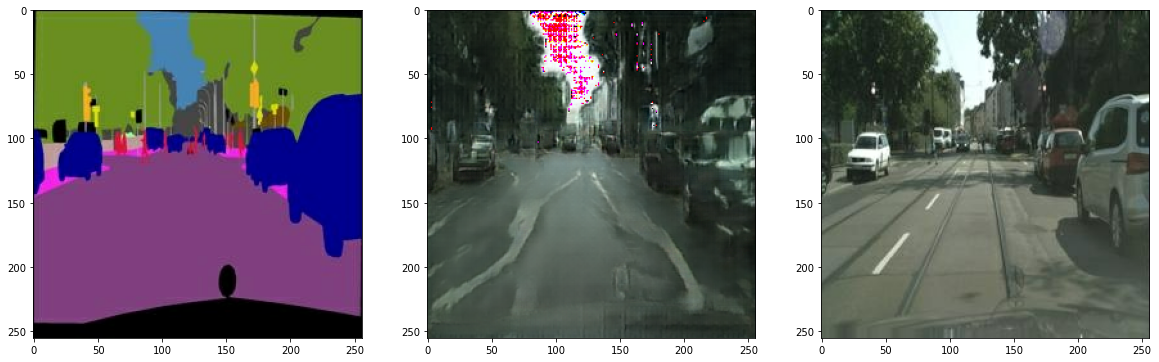

In [28]:
# 200epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [29]:
# 추가 200 epochs train
EPOCHS = 200

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:0.5044                     
L1_loss:0.1620                     
Discriminator_loss:2.2286

EPOCH[1] - STEP[100]                     
Generator_loss:1.5873                     
L1_loss:0.1452                     
Discriminator_loss:1.0067

EPOCH[1] - STEP[150]                     
Generator_loss:1.5431                     
L1_loss:0.1615                     
Discriminator_loss:1.0579

EPOCH[1] - STEP[200]                     
Generator_loss:1.5163                     
L1_loss:0.1648                     
Discriminator_loss:0.3812

EPOCH[1] - STEP[250]                     
Generator_loss:1.7897                     
L1_loss:0.1988                     
Discriminator_loss:0.3945

EPOCH[2] - STEP[50]                     
Generator_loss:1.0934                     
L1_loss:0.1648                     
Discriminator_loss:0.5321

EPOCH[2] - STEP[100]                     
Generator_loss:2.3404                     
L1_loss:0.1509               

EPOCH[12] - STEP[100]                     
Generator_loss:2.2702                     
L1_loss:0.1497                     
Discriminator_loss:0.4958

EPOCH[12] - STEP[150]                     
Generator_loss:2.4748                     
L1_loss:0.1558                     
Discriminator_loss:0.7963

EPOCH[12] - STEP[200]                     
Generator_loss:0.8743                     
L1_loss:0.1846                     
Discriminator_loss:0.7089

EPOCH[12] - STEP[250]                     
Generator_loss:1.5177                     
L1_loss:0.1856                     
Discriminator_loss:1.0752

EPOCH[13] - STEP[50]                     
Generator_loss:0.8249                     
L1_loss:0.1742                     
Discriminator_loss:1.5149

EPOCH[13] - STEP[100]                     
Generator_loss:1.5371                     
L1_loss:0.1510                     
Discriminator_loss:0.6664

EPOCH[13] - STEP[150]                     
Generator_loss:0.6997                     
L1_loss:0.1858       

EPOCH[23] - STEP[150]                     
Generator_loss:1.0925                     
L1_loss:0.1573                     
Discriminator_loss:0.8267

EPOCH[23] - STEP[200]                     
Generator_loss:1.8802                     
L1_loss:0.1496                     
Discriminator_loss:0.5127

EPOCH[23] - STEP[250]                     
Generator_loss:1.6163                     
L1_loss:0.1438                     
Discriminator_loss:0.6628

EPOCH[24] - STEP[50]                     
Generator_loss:2.2911                     
L1_loss:0.1823                     
Discriminator_loss:0.4926

EPOCH[24] - STEP[100]                     
Generator_loss:0.6662                     
L1_loss:0.1542                     
Discriminator_loss:0.9236

EPOCH[24] - STEP[150]                     
Generator_loss:1.4263                     
L1_loss:0.1927                     
Discriminator_loss:0.3705

EPOCH[24] - STEP[200]                     
Generator_loss:0.8722                     
L1_loss:0.1690       

EPOCH[34] - STEP[200]                     
Generator_loss:2.1951                     
L1_loss:0.1664                     
Discriminator_loss:0.4167

EPOCH[34] - STEP[250]                     
Generator_loss:2.1698                     
L1_loss:0.1481                     
Discriminator_loss:1.2004

EPOCH[35] - STEP[50]                     
Generator_loss:1.3978                     
L1_loss:0.1710                     
Discriminator_loss:1.0784

EPOCH[35] - STEP[100]                     
Generator_loss:1.6360                     
L1_loss:0.1750                     
Discriminator_loss:0.7437

EPOCH[35] - STEP[150]                     
Generator_loss:1.8874                     
L1_loss:0.1813                     
Discriminator_loss:0.3670

EPOCH[35] - STEP[200]                     
Generator_loss:1.2462                     
L1_loss:0.1657                     
Discriminator_loss:0.7424

EPOCH[35] - STEP[250]                     
Generator_loss:2.0874                     
L1_loss:0.1686       

EPOCH[45] - STEP[250]                     
Generator_loss:1.2659                     
L1_loss:0.1315                     
Discriminator_loss:1.2961

EPOCH[46] - STEP[50]                     
Generator_loss:1.7053                     
L1_loss:0.1926                     
Discriminator_loss:0.3242

EPOCH[46] - STEP[100]                     
Generator_loss:1.5835                     
L1_loss:0.1423                     
Discriminator_loss:0.9388

EPOCH[46] - STEP[150]                     
Generator_loss:1.5159                     
L1_loss:0.1788                     
Discriminator_loss:0.4275

EPOCH[46] - STEP[200]                     
Generator_loss:1.5140                     
L1_loss:0.1582                     
Discriminator_loss:0.7128

EPOCH[46] - STEP[250]                     
Generator_loss:0.6091                     
L1_loss:0.1343                     
Discriminator_loss:1.5050

EPOCH[47] - STEP[50]                     
Generator_loss:2.3854                     
L1_loss:0.1851        

EPOCH[57] - STEP[50]                     
Generator_loss:0.7837                     
L1_loss:0.1472                     
Discriminator_loss:1.4600

EPOCH[57] - STEP[100]                     
Generator_loss:1.2849                     
L1_loss:0.1893                     
Discriminator_loss:0.5647

EPOCH[57] - STEP[150]                     
Generator_loss:1.0999                     
L1_loss:0.1467                     
Discriminator_loss:1.2175

EPOCH[57] - STEP[200]                     
Generator_loss:1.0408                     
L1_loss:0.1833                     
Discriminator_loss:0.6437

EPOCH[57] - STEP[250]                     
Generator_loss:1.0651                     
L1_loss:0.1824                     
Discriminator_loss:0.5792

EPOCH[58] - STEP[50]                     
Generator_loss:1.2545                     
L1_loss:0.1785                     
Discriminator_loss:0.8420

EPOCH[58] - STEP[100]                     
Generator_loss:1.4966                     
L1_loss:0.1544        

EPOCH[68] - STEP[100]                     
Generator_loss:1.2927                     
L1_loss:0.1542                     
Discriminator_loss:0.4648

EPOCH[68] - STEP[150]                     
Generator_loss:1.7228                     
L1_loss:0.1969                     
Discriminator_loss:0.2833

EPOCH[68] - STEP[200]                     
Generator_loss:0.4833                     
L1_loss:0.1740                     
Discriminator_loss:1.3358

EPOCH[68] - STEP[250]                     
Generator_loss:1.6808                     
L1_loss:0.1623                     
Discriminator_loss:0.4932

EPOCH[69] - STEP[50]                     
Generator_loss:0.7602                     
L1_loss:0.1601                     
Discriminator_loss:0.9903

EPOCH[69] - STEP[100]                     
Generator_loss:2.2061                     
L1_loss:0.1552                     
Discriminator_loss:0.5516

EPOCH[69] - STEP[150]                     
Generator_loss:0.9593                     
L1_loss:0.1552       

EPOCH[79] - STEP[150]                     
Generator_loss:0.7455                     
L1_loss:0.1589                     
Discriminator_loss:0.9689

EPOCH[79] - STEP[200]                     
Generator_loss:1.7064                     
L1_loss:0.1812                     
Discriminator_loss:0.5302

EPOCH[79] - STEP[250]                     
Generator_loss:0.5456                     
L1_loss:0.1554                     
Discriminator_loss:1.2062

EPOCH[80] - STEP[50]                     
Generator_loss:1.0711                     
L1_loss:0.1539                     
Discriminator_loss:0.6487

EPOCH[80] - STEP[100]                     
Generator_loss:1.8874                     
L1_loss:0.1458                     
Discriminator_loss:0.8784

EPOCH[80] - STEP[150]                     
Generator_loss:1.7677                     
L1_loss:0.1596                     
Discriminator_loss:0.6289

EPOCH[80] - STEP[200]                     
Generator_loss:2.7115                     
L1_loss:0.1520       

EPOCH[90] - STEP[200]                     
Generator_loss:1.5825                     
L1_loss:0.1561                     
Discriminator_loss:0.5750

EPOCH[90] - STEP[250]                     
Generator_loss:1.3421                     
L1_loss:0.1513                     
Discriminator_loss:1.0126

EPOCH[91] - STEP[50]                     
Generator_loss:1.4450                     
L1_loss:0.1834                     
Discriminator_loss:1.1730

EPOCH[91] - STEP[100]                     
Generator_loss:0.9182                     
L1_loss:0.1494                     
Discriminator_loss:1.1242

EPOCH[91] - STEP[150]                     
Generator_loss:1.1718                     
L1_loss:0.1445                     
Discriminator_loss:0.9376

EPOCH[91] - STEP[200]                     
Generator_loss:0.5282                     
L1_loss:0.1598                     
Discriminator_loss:1.2163

EPOCH[91] - STEP[250]                     
Generator_loss:1.9699                     
L1_loss:0.1511       

EPOCH[101] - STEP[250]                     
Generator_loss:0.7583                     
L1_loss:0.2113                     
Discriminator_loss:0.7962

EPOCH[102] - STEP[50]                     
Generator_loss:0.5056                     
L1_loss:0.1462                     
Discriminator_loss:1.3239

EPOCH[102] - STEP[100]                     
Generator_loss:1.0564                     
L1_loss:0.1756                     
Discriminator_loss:0.5874

EPOCH[102] - STEP[150]                     
Generator_loss:2.0952                     
L1_loss:0.1431                     
Discriminator_loss:0.8887

EPOCH[102] - STEP[200]                     
Generator_loss:1.7615                     
L1_loss:0.1978                     
Discriminator_loss:0.2724

EPOCH[102] - STEP[250]                     
Generator_loss:0.8769                     
L1_loss:0.1479                     
Discriminator_loss:0.9427

EPOCH[103] - STEP[50]                     
Generator_loss:1.5060                     
L1_loss:0.1643 

EPOCH[112] - STEP[250]                     
Generator_loss:1.3840                     
L1_loss:0.1491                     
Discriminator_loss:0.9858

EPOCH[113] - STEP[50]                     
Generator_loss:1.7012                     
L1_loss:0.1708                     
Discriminator_loss:0.3640

EPOCH[113] - STEP[100]                     
Generator_loss:0.6209                     
L1_loss:0.1790                     
Discriminator_loss:1.0429

EPOCH[113] - STEP[150]                     
Generator_loss:1.3728                     
L1_loss:0.1738                     
Discriminator_loss:0.5240

EPOCH[113] - STEP[200]                     
Generator_loss:1.8271                     
L1_loss:0.1698                     
Discriminator_loss:0.4557

EPOCH[113] - STEP[250]                     
Generator_loss:0.6726                     
L1_loss:0.1398                     
Discriminator_loss:1.1772

EPOCH[114] - STEP[50]                     
Generator_loss:1.5724                     
L1_loss:0.1245 

EPOCH[123] - STEP[250]                     
Generator_loss:1.1253                     
L1_loss:0.1661                     
Discriminator_loss:1.2750

EPOCH[124] - STEP[50]                     
Generator_loss:1.3617                     
L1_loss:0.1694                     
Discriminator_loss:0.4032

EPOCH[124] - STEP[100]                     
Generator_loss:2.0694                     
L1_loss:0.1495                     
Discriminator_loss:0.8058

EPOCH[124] - STEP[150]                     
Generator_loss:1.6571                     
L1_loss:0.1544                     
Discriminator_loss:0.6263

EPOCH[124] - STEP[200]                     
Generator_loss:2.9962                     
L1_loss:0.1519                     
Discriminator_loss:1.4383

EPOCH[124] - STEP[250]                     
Generator_loss:1.4584                     
L1_loss:0.1251                     
Discriminator_loss:1.8373

EPOCH[125] - STEP[50]                     
Generator_loss:1.0617                     
L1_loss:0.1619 

EPOCH[134] - STEP[250]                     
Generator_loss:2.1461                     
L1_loss:0.1236                     
Discriminator_loss:1.2825

EPOCH[135] - STEP[50]                     
Generator_loss:1.7535                     
L1_loss:0.1706                     
Discriminator_loss:1.0601

EPOCH[135] - STEP[100]                     
Generator_loss:1.9049                     
L1_loss:0.1495                     
Discriminator_loss:0.5421

EPOCH[135] - STEP[150]                     
Generator_loss:0.6084                     
L1_loss:0.1921                     
Discriminator_loss:1.0151

EPOCH[135] - STEP[200]                     
Generator_loss:2.5642                     
L1_loss:0.1666                     
Discriminator_loss:1.0617

EPOCH[135] - STEP[250]                     
Generator_loss:1.0550                     
L1_loss:0.1250                     
Discriminator_loss:0.8646

EPOCH[136] - STEP[50]                     
Generator_loss:1.1740                     
L1_loss:0.1533 

EPOCH[145] - STEP[250]                     
Generator_loss:0.3300                     
L1_loss:0.1657                     
Discriminator_loss:2.4980

EPOCH[146] - STEP[50]                     
Generator_loss:1.4851                     
L1_loss:0.1551                     
Discriminator_loss:1.2645

EPOCH[146] - STEP[100]                     
Generator_loss:1.0886                     
L1_loss:0.1529                     
Discriminator_loss:0.5767

EPOCH[146] - STEP[150]                     
Generator_loss:1.4755                     
L1_loss:0.1823                     
Discriminator_loss:0.3663

EPOCH[146] - STEP[200]                     
Generator_loss:0.9265                     
L1_loss:0.1342                     
Discriminator_loss:1.5224

EPOCH[146] - STEP[250]                     
Generator_loss:1.5813                     
L1_loss:0.1496                     
Discriminator_loss:0.5942

EPOCH[147] - STEP[50]                     
Generator_loss:1.3201                     
L1_loss:0.1581 

EPOCH[156] - STEP[250]                     
Generator_loss:2.0432                     
L1_loss:0.1724                     
Discriminator_loss:0.4569

EPOCH[157] - STEP[50]                     
Generator_loss:1.1983                     
L1_loss:0.1562                     
Discriminator_loss:0.7388

EPOCH[157] - STEP[100]                     
Generator_loss:1.1856                     
L1_loss:0.1225                     
Discriminator_loss:1.0201

EPOCH[157] - STEP[150]                     
Generator_loss:1.4229                     
L1_loss:0.1286                     
Discriminator_loss:1.1073

EPOCH[157] - STEP[200]                     
Generator_loss:2.5218                     
L1_loss:0.1634                     
Discriminator_loss:0.5464

EPOCH[157] - STEP[250]                     
Generator_loss:0.9974                     
L1_loss:0.1629                     
Discriminator_loss:0.7620

EPOCH[158] - STEP[50]                     
Generator_loss:2.2098                     
L1_loss:0.1633 

EPOCH[167] - STEP[250]                     
Generator_loss:1.6937                     
L1_loss:0.1887                     
Discriminator_loss:0.2868

EPOCH[168] - STEP[50]                     
Generator_loss:1.4238                     
L1_loss:0.1457                     
Discriminator_loss:0.8542

EPOCH[168] - STEP[100]                     
Generator_loss:1.5371                     
L1_loss:0.1759                     
Discriminator_loss:0.3903

EPOCH[168] - STEP[150]                     
Generator_loss:1.9469                     
L1_loss:0.1562                     
Discriminator_loss:1.4773

EPOCH[168] - STEP[200]                     
Generator_loss:1.5011                     
L1_loss:0.1823                     
Discriminator_loss:0.4586

EPOCH[168] - STEP[250]                     
Generator_loss:0.2824                     
L1_loss:0.1866                     
Discriminator_loss:1.7088

EPOCH[169] - STEP[50]                     
Generator_loss:0.9739                     
L1_loss:0.1648 

EPOCH[178] - STEP[250]                     
Generator_loss:1.1596                     
L1_loss:0.1433                     
Discriminator_loss:0.5794

EPOCH[179] - STEP[50]                     
Generator_loss:2.1668                     
L1_loss:0.1447                     
Discriminator_loss:2.0597

EPOCH[179] - STEP[100]                     
Generator_loss:0.8034                     
L1_loss:0.1620                     
Discriminator_loss:0.8034

EPOCH[179] - STEP[150]                     
Generator_loss:1.8073                     
L1_loss:0.1604                     
Discriminator_loss:0.5047

EPOCH[179] - STEP[200]                     
Generator_loss:0.7306                     
L1_loss:0.1640                     
Discriminator_loss:0.9849

EPOCH[179] - STEP[250]                     
Generator_loss:0.8095                     
L1_loss:0.1260                     
Discriminator_loss:0.9803

EPOCH[180] - STEP[50]                     
Generator_loss:1.8349                     
L1_loss:0.1619 

EPOCH[189] - STEP[250]                     
Generator_loss:1.3703                     
L1_loss:0.1475                     
Discriminator_loss:0.8278

EPOCH[190] - STEP[50]                     
Generator_loss:2.1304                     
L1_loss:0.1500                     
Discriminator_loss:0.4571

EPOCH[190] - STEP[100]                     
Generator_loss:1.3551                     
L1_loss:0.1378                     
Discriminator_loss:1.3410

EPOCH[190] - STEP[150]                     
Generator_loss:1.4042                     
L1_loss:0.1573                     
Discriminator_loss:1.2594

EPOCH[190] - STEP[200]                     
Generator_loss:2.3994                     
L1_loss:0.1597                     
Discriminator_loss:0.6027

EPOCH[190] - STEP[250]                     
Generator_loss:0.8458                     
L1_loss:0.1502                     
Discriminator_loss:1.4201

EPOCH[191] - STEP[50]                     
Generator_loss:2.4422                     
L1_loss:0.1315 

EPOCH[200] - STEP[250]                     
Generator_loss:1.1880                     
L1_loss:0.1381                     
Discriminator_loss:1.5303



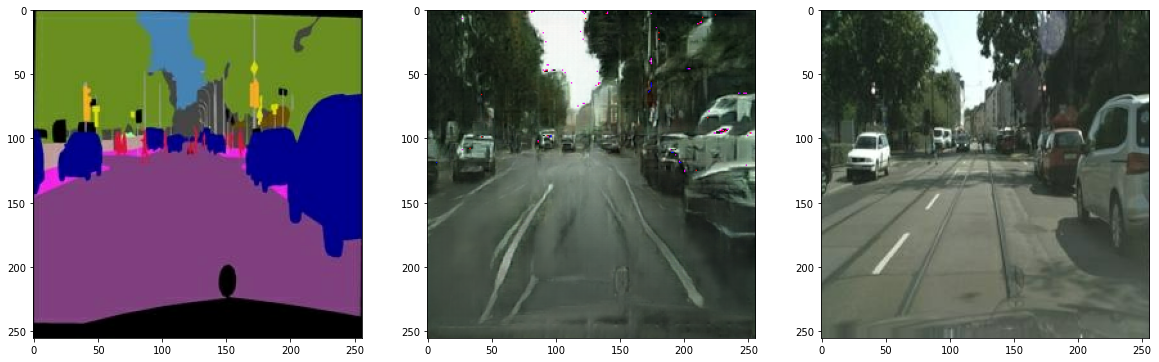

In [30]:
# 400epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [32]:
%%time
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:2.0892                     
L1_loss:0.1744                     
Discriminator_loss:0.5157

EPOCH[1] - STEP[100]                     
Generator_loss:0.8866                     
L1_loss:0.1311                     
Discriminator_loss:1.1274

EPOCH[1] - STEP[150]                     
Generator_loss:2.1894                     
L1_loss:0.1627                     
Discriminator_loss:2.9292

EPOCH[1] - STEP[200]                     
Generator_loss:0.7443                     
L1_loss:0.1740                     
Discriminator_loss:1.4638

EPOCH[1] - STEP[250]                     
Generator_loss:1.6890                     
L1_loss:0.1639                     
Discriminator_loss:0.4884

EPOCH[2] - STEP[50]                     
Generator_loss:1.3331                     
L1_loss:0.1333                     
Discriminator_loss:0.5892

EPOCH[2] - STEP[100]                     
Generator_loss:2.1865                     
L1_loss:0.1444               

EPOCH[12] - STEP[100]                     
Generator_loss:1.9586                     
L1_loss:0.1229                     
Discriminator_loss:1.2222

EPOCH[12] - STEP[150]                     
Generator_loss:0.6944                     
L1_loss:0.1871                     
Discriminator_loss:0.8841

EPOCH[12] - STEP[200]                     
Generator_loss:0.9368                     
L1_loss:0.1506                     
Discriminator_loss:1.4264

EPOCH[12] - STEP[250]                     
Generator_loss:2.3473                     
L1_loss:0.1655                     
Discriminator_loss:0.6113

EPOCH[13] - STEP[50]                     
Generator_loss:1.1861                     
L1_loss:0.1518                     
Discriminator_loss:0.9231

EPOCH[13] - STEP[100]                     
Generator_loss:1.9127                     
L1_loss:0.1604                     
Discriminator_loss:0.7370

EPOCH[13] - STEP[150]                     
Generator_loss:1.3579                     
L1_loss:0.1527       

EPOCH[23] - STEP[150]                     
Generator_loss:1.4195                     
L1_loss:0.1449                     
Discriminator_loss:0.4450

EPOCH[23] - STEP[200]                     
Generator_loss:1.0593                     
L1_loss:0.1699                     
Discriminator_loss:0.6489

EPOCH[23] - STEP[250]                     
Generator_loss:2.0183                     
L1_loss:0.1610                     
Discriminator_loss:1.5018

EPOCH[24] - STEP[50]                     
Generator_loss:0.5036                     
L1_loss:0.1416                     
Discriminator_loss:1.2703

EPOCH[24] - STEP[100]                     
Generator_loss:0.5838                     
L1_loss:0.1494                     
Discriminator_loss:1.3312

EPOCH[24] - STEP[150]                     
Generator_loss:2.6014                     
L1_loss:0.1813                     
Discriminator_loss:0.5056

EPOCH[24] - STEP[200]                     
Generator_loss:1.0966                     
L1_loss:0.1406       

EPOCH[34] - STEP[200]                     
Generator_loss:0.7226                     
L1_loss:0.1438                     
Discriminator_loss:1.1454

EPOCH[34] - STEP[250]                     
Generator_loss:1.1735                     
L1_loss:0.1462                     
Discriminator_loss:0.7716

EPOCH[35] - STEP[50]                     
Generator_loss:1.2603                     
L1_loss:0.1436                     
Discriminator_loss:0.6751

EPOCH[35] - STEP[100]                     
Generator_loss:1.3961                     
L1_loss:0.1581                     
Discriminator_loss:0.4862

EPOCH[35] - STEP[150]                     
Generator_loss:2.3429                     
L1_loss:0.1429                     
Discriminator_loss:1.4731

EPOCH[35] - STEP[200]                     
Generator_loss:0.8607                     
L1_loss:0.1494                     
Discriminator_loss:1.0817

EPOCH[35] - STEP[250]                     
Generator_loss:1.0489                     
L1_loss:0.1626       

EPOCH[45] - STEP[250]                     
Generator_loss:1.1724                     
L1_loss:0.1551                     
Discriminator_loss:1.6570

EPOCH[46] - STEP[50]                     
Generator_loss:2.6884                     
L1_loss:0.1409                     
Discriminator_loss:1.8289

EPOCH[46] - STEP[100]                     
Generator_loss:3.5065                     
L1_loss:0.1643                     
Discriminator_loss:1.1188

EPOCH[46] - STEP[150]                     
Generator_loss:1.0715                     
L1_loss:0.1450                     
Discriminator_loss:1.0539

EPOCH[46] - STEP[200]                     
Generator_loss:1.7793                     
L1_loss:0.1603                     
Discriminator_loss:0.2802

EPOCH[46] - STEP[250]                     
Generator_loss:0.8786                     
L1_loss:0.1834                     
Discriminator_loss:0.9708

EPOCH[47] - STEP[50]                     
Generator_loss:1.4010                     
L1_loss:0.1287        

EPOCH[57] - STEP[50]                     
Generator_loss:0.9010                     
L1_loss:0.1657                     
Discriminator_loss:0.8381

EPOCH[57] - STEP[100]                     
Generator_loss:1.1731                     
L1_loss:0.1904                     
Discriminator_loss:0.4969

EPOCH[57] - STEP[150]                     
Generator_loss:0.3219                     
L1_loss:0.1476                     
Discriminator_loss:1.7179

EPOCH[57] - STEP[200]                     
Generator_loss:0.9885                     
L1_loss:0.1298                     
Discriminator_loss:0.7729

EPOCH[57] - STEP[250]                     
Generator_loss:1.7850                     
L1_loss:0.1769                     
Discriminator_loss:0.3009

EPOCH[58] - STEP[50]                     
Generator_loss:1.2840                     
L1_loss:0.1300                     
Discriminator_loss:1.2312

EPOCH[58] - STEP[100]                     
Generator_loss:1.6498                     
L1_loss:0.1621        

EPOCH[68] - STEP[100]                     
Generator_loss:0.4316                     
L1_loss:0.1639                     
Discriminator_loss:1.4309

EPOCH[68] - STEP[150]                     
Generator_loss:1.6017                     
L1_loss:0.1626                     
Discriminator_loss:0.6062

EPOCH[68] - STEP[200]                     
Generator_loss:1.6784                     
L1_loss:0.1631                     
Discriminator_loss:0.3824

EPOCH[68] - STEP[250]                     
Generator_loss:1.7896                     
L1_loss:0.1524                     
Discriminator_loss:0.4434

EPOCH[69] - STEP[50]                     
Generator_loss:1.4913                     
L1_loss:0.1422                     
Discriminator_loss:0.9290

EPOCH[69] - STEP[100]                     
Generator_loss:1.9607                     
L1_loss:0.1326                     
Discriminator_loss:1.2923

EPOCH[69] - STEP[150]                     
Generator_loss:1.8278                     
L1_loss:0.1530       

EPOCH[79] - STEP[150]                     
Generator_loss:1.8801                     
L1_loss:0.1528                     
Discriminator_loss:0.6706

EPOCH[79] - STEP[200]                     
Generator_loss:0.5988                     
L1_loss:0.1573                     
Discriminator_loss:1.0758

EPOCH[79] - STEP[250]                     
Generator_loss:0.8303                     
L1_loss:0.1644                     
Discriminator_loss:0.8545

EPOCH[80] - STEP[50]                     
Generator_loss:1.5880                     
L1_loss:0.1451                     
Discriminator_loss:0.7578

EPOCH[80] - STEP[100]                     
Generator_loss:1.2933                     
L1_loss:0.1461                     
Discriminator_loss:0.5634

EPOCH[80] - STEP[150]                     
Generator_loss:2.0811                     
L1_loss:0.1459                     
Discriminator_loss:0.6670

EPOCH[80] - STEP[200]                     
Generator_loss:0.8649                     
L1_loss:0.1663       

EPOCH[90] - STEP[200]                     
Generator_loss:0.7949                     
L1_loss:0.1462                     
Discriminator_loss:0.9783

EPOCH[90] - STEP[250]                     
Generator_loss:1.1546                     
L1_loss:0.1538                     
Discriminator_loss:0.5582

EPOCH[91] - STEP[50]                     
Generator_loss:1.9150                     
L1_loss:0.1255                     
Discriminator_loss:1.1276

EPOCH[91] - STEP[100]                     
Generator_loss:1.0270                     
L1_loss:0.1385                     
Discriminator_loss:1.1460

EPOCH[91] - STEP[150]                     
Generator_loss:2.6551                     
L1_loss:0.1433                     
Discriminator_loss:0.4819

EPOCH[91] - STEP[200]                     
Generator_loss:2.3524                     
L1_loss:0.1233                     
Discriminator_loss:1.4561

EPOCH[91] - STEP[250]                     
Generator_loss:1.8414                     
L1_loss:0.1362       

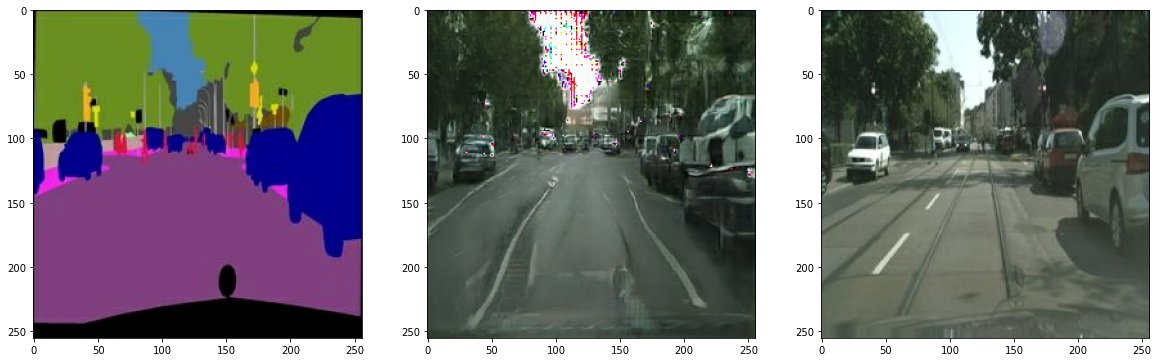

In [33]:
# 500epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [40]:
generator.save('./models/generator_500epochs')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/generator_500epochs/assets


In [42]:
discriminator.save_weights('./models/discriminator_500epochs')

## 회고록

- 이전에 DCGAN 노드를 할 때 열심히 공부했었기 때문에 이번 노드는 상대적으로 수월하게 진행할 수 있었다.
- DCGAN 노드를 진행할 때 왜 label을 활용하지 않을까에 대한 의문이 있었는데 이번 노드를 통해 그 궁금증이 해결된 것 같다.
- 학습 노드에서 진행한 것과 프로젝트에서의 train이랑 label이 반대로 되어있는 걸 못보고 400epochs 정도를 돌렸다. 당연히 원하는 이미지가 나오지 않아서 다시 돌리니 10epochs 만으로도 학습이 되는 걸 확인할 수 있는 이미지가 나왔다.
- 100, 200, 400, 500 epochs을 돌려본 결과, 확실히 이전에 Label 없이 학습했을 때 보다 이미지를 더 잘 생성하는 것 같다.